In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 73.7 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
params = {
  'WLSACCESSID':'24738a6d-7010-4a14-b7f9-96e3f68dba1d',
  'WLSSECRET':'1f578b08-da1e-47e9-8f1c-edce1f91a2c4',
  'LICENSEID':2426147
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2426147
Academic license - for non-commercial use only - registered to kehl.li@utexas.edu


# Data Preparation

In [ ]:
train = pd.read_csv('stocks2019.csv', index_col=0)
train

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,8696.009766,58.505219,328.950012,45.459999,110.459999,278.140015,1350.630005,1348.839966,1793.000000,238.099670,...,34.660000,253.020004,192.429993,148.814499,219.979996,56.759140,165.610001,61.401749,61.415092,97.683632
2019-12-24,8699.509766,58.425743,329.640015,46.540001,110.279999,277.890015,1344.430054,1343.560059,1789.209961,237.413879,...,34.470001,252.490005,192.750000,148.436371,220.559998,56.545940,166.190002,60.941479,61.655396,97.278679
2019-12-26,8778.309570,58.505219,331.200012,46.630001,108.930000,278.260010,1362.469971,1360.400024,1868.770020,236.992599,...,34.570000,251.330002,193.710007,148.098038,220.250000,57.078938,165.360001,61.499676,61.586739,97.466339


In [ ]:
train_return = train.pct_change().iloc[1:, 1:]
train_return

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,-0.005572,0.004090,0.029672,0.006469,0.019239,-0.000437,-0.000556,0.003638,-0.000123,-0.005425,...,0.002603,0.010060,-0.000104,-0.000869,-0.003217,0.003083,-0.009273,0.026019,-0.017615,0.011868
2019-12-24,-0.001358,0.002098,0.023757,-0.001630,-0.000899,-0.004590,-0.003914,-0.002114,-0.002880,0.004615,...,-0.005482,-0.002095,0.001663,-0.002541,0.002637,-0.003756,0.003502,-0.007496,0.003913,-0.004146
2019-12-26,0.001360,0.004732,0.001934,-0.012242,0.001331,0.013418,0.012534,0.044467,-0.001774,0.000084,...,0.002901,-0.004594,0.004981,-0.002279,-0.001406,0.009426,-0.004994,0.009160,-0.001114,0.001929


In [ ]:
rho_train = train_return.corr()
rho_train

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,0.347861,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,0.351734,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,0.602935,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,-0.047259,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552


In [ ]:
test = pd.read_csv('stocks2020.csv', index_col=0)
test

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
1/2/20,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,231.917572,...,36.970001,254.550003,196.729996,150.167465,219.449997,56.046688,167.460007,64.771545,60.782249,100.115349
1/3/20,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,230.343124,...,36.180000,250.169998,200.880005,151.628220,217.979996,56.046688,168.440002,63.774597,61.074562,97.810677
1/6/20,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,232.110748,...,35.689999,250.949997,202.740005,151.976013,224.029999,56.530506,169.490005,62.550629,60.986866,95.771927
1/7/20,8846.450195,59.945747,333.390015,48.250000,106.849998,283.059998,1395.109985,1393.339966,1906.859985,229.927765,...,37.330002,253.089996,203.210007,153.247955,223.789993,56.245903,172.949997,66.785164,60.860199,97.958405
1/8/20,8912.370117,59.488754,337.869995,47.830002,108.580002,286.000000,1405.040039,1404.319946,1891.969971,230.101654,...,36.869999,258.000000,204.149994,154.658997,231.089996,52.963551,178.710007,67.752487,60.801735,97.682640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/23/20,12653.139650,90.209999,496.910004,91.550003,153.240005,525.000000,1728.229980,1732.380005,3185.270020,221.294556,...,32.630001,268.459991,214.009995,199.970001,235.839996,39.493504,248.759995,49.930000,64.309998,141.990005
12/24/20,12711.009770,90.959999,499.859985,91.809998,152.630005,528.030029,1734.160034,1738.849976,3172.689941,221.284622,...,31.990000,264.640015,214.589996,201.229996,234.460007,39.245865,248.759995,49.919998,64.629997,141.990005
12/28/20,12838.860350,91.430000,498.950012,91.599998,154.360001,520.859985,1773.959961,1776.089966,3283.959961,221.999313,...,31.900000,278.170013,216.800003,207.979996,232.470001,39.285488,241.919998,50.060001,65.320000,141.520004
12/29/20,12843.490230,91.370003,502.109985,90.620003,155.350006,520.450012,1757.760010,1758.719971,3322.000000,225.195541,...,32.029999,277.339996,215.630005,205.669998,233.490005,39.037846,237.720001,48.290001,65.419998,139.899994


In [ ]:
test_return = test.pct_change().iloc[1:, 1:]
test_return

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
1/3/20,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,-0.017604,...,-0.021369,-0.017207,0.021095,0.009728,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
1/6/20,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,-0.011749,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
1/7/20,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,0.022751,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005035,0.020414,0.067698,-0.002077,0.022830
1/8/20,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,0.009032,...,-0.012323,0.019400,0.004626,0.009208,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
1/9/20,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,0.000000,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/23/20,0.008835,-0.014400,-0.017282,-0.003706,-0.021599,0.004656,0.005152,-0.006627,0.008824,-0.007347,...,-0.009712,0.012713,-0.010770,-0.009706,0.004002,0.015279,-0.034729,0.004224,-0.008021,-0.015053
12/24/20,0.008314,0.005937,0.002840,-0.003981,0.005771,0.003431,0.003735,-0.003949,-0.000045,0.008728,...,-0.019614,-0.014229,0.002710,0.006301,-0.005851,-0.006270,0.000000,-0.000200,0.004976,0.000000
12/28/20,0.005167,-0.001820,-0.002287,0.011335,-0.013579,0.022951,0.021416,0.035071,0.003230,0.001454,...,-0.002813,0.051126,0.010299,0.033544,-0.008488,0.001010,-0.027496,0.002805,0.010676,-0.003310
12/29/20,-0.000656,0.006333,-0.010699,0.006414,-0.000787,-0.009132,-0.009780,0.011584,0.014397,-0.007050,...,0.004075,-0.002984,-0.005397,-0.011107,0.004388,-0.006304,-0.017361,-0.035358,0.001531,-0.011447


In [ ]:
n = len(train_return.columns)
n

100

In [ ]:
train_q = train.iloc[:, 0].pct_change().iloc[1:]
train_q

X
2019-01-03   -0.033602
2019-01-04    0.044824
2019-01-07    0.010211
2019-01-08    0.009802
2019-01-09    0.007454
                ...   
2019-12-23    0.002019
2019-12-24    0.000402
2019-12-26    0.009058
2019-12-27   -0.000835
2019-12-30   -0.006983
Name: NDX, Length: 250, dtype: float64

In [ ]:
test_q = test.iloc[:, 0].pct_change().iloc[1:]
test_q

1/3/20     -0.008827
1/6/20      0.006211
1/7/20     -0.000234
1/8/20      0.007452
1/9/20      0.008669
              ...   
12/23/20   -0.005065
12/24/20    0.004574
12/28/20    0.010058
12/29/20    0.000361
12/30/20    0.000146
Name: NDX, Length: 251, dtype: float64

In [ ]:
T = len(train_return)
T

250

In [ ]:
T2 = len(test_return)
T2

251

# Stock Selection

In [ ]:
selection = gp.Model(env=env)
X = selection.addMVar((n,n), vtype='B')
Y = selection.addMVar(n, vtype='B')

In [ ]:
target = gp.quicksum(gp.quicksum(X[i][j]*rho_train.iloc[i, j] for i in range(n)) for j in range(n))

In [ ]:
selection.setObjective(target, sense=gp.GRB.MAXIMIZE)

In [ ]:
m = 5
total_con = selection.addConstr(gp.quicksum(Y[j] for j in range(n))==m)
row_con = selection.addConstrs(gp.quicksum(X[i][j] for j in range(n))==1 for i in range(n))
select_con = selection.addConstrs(X[i][j]<=Y[j] for i in range(n) for j in range(n))

In [ ]:
selection.Params.OutputFlag = 0
selection.optimize()

## Results for the chosen stocks and a grid of most similar chosen stocks to each stock

In [ ]:
Y_indices = np.where(Y.x == 1)
Y_indices

(array([56, 59, 63, 94, 98]),)

In [ ]:
selected = rho_train.index[Y_indices]
selected

Index(['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL'], dtype='object')

In [ ]:
X_indices = np.where(X.x == 1)
X_indices

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([63, 63, 63, 94, 63, 63, 63, 63, 94, 59, 63, 63, 59, 59, 63, 63, 59,
        94, 94, 63, 59, 63, 63, 63, 56, 63, 63, 63, 63, 63, 63, 63, 63, 59,
        63, 63, 59, 63, 63, 98, 59, 63, 59, 63, 94, 63, 63, 94, 59, 63, 63,
        63, 59, 59, 59, 56, 56, 63, 59, 59, 63, 59, 59, 63, 94, 98, 63, 63,
        63, 59, 59, 63, 59, 63, 63, 98, 59, 59, 94, 63, 94, 63, 59, 63, 63,
        63, 59, 63, 59, 59, 59, 63, 63, 63, 94, 59, 63, 59, 98, 59]))

In [ ]:
sim = pd.DataFrame(index=rho_train.index, columns=['Similar Stock'])
for i in range(n):
  sim.iloc[i] = sim.index[X_indices[1][i]]
sim

,Similar Stock
ATVI,MSFT
ADBE,MSFT
AMD,MSFT
ALXN,VRTX
ALGN,MSFT
...,...
WBA,MXIM
WDAY,MSFT
WDC,MXIM
XEL,XEL


# Portfolio weight

In [ ]:
Y_indices[0]

array([56, 59, 63, 94, 98])

## Important definitions to the expression

$$r_{it} = selected\_return.iloc[t,i]$$

$$q_t = train\_q.iloc[t]$$

In [ ]:
selected_return = train_return.iloc[:,Y_indices[0].tolist()]
selected_return

,LBTYK,MXIM,MSFT,VRTX,XEL
X,,,,,
2019-01-03,-0.006280,-0.056845,-0.036788,-0.002133,-0.003940
2019-01-04,0.068546,0.044004,0.046509,0.054785,0.009786
2019-01-07,-0.042766,0.010388,0.001275,0.018240,-0.004330
2019-01-08,-0.036122,-0.015026,0.007251,0.013307,0.011597
2019-01-09,0.002959,0.027098,0.014300,0.023065,-0.007984
...,...,...,...,...,...
2019-12-23,0.004617,-0.004213,0.000000,-0.003217,-0.017615
2019-12-24,0.000919,-0.002604,-0.000191,0.002637,0.003913
2019-12-26,-0.016988,0.006526,0.008197,-0.001406,-0.001114


In [ ]:
weight = gp.Model(env=env)
y = weight.addMVar(T)
w = weight.addMVar(m)

In [ ]:
sum_con = weight.addConstr(sum(w)==1)

In [ ]:
y_form = [train_q[t]-gp.quicksum(selected_return.iloc[t,i]*w[i] for i in range(m)) for t in range(T)]

In [ ]:
up_con = weight.addConstrs(y[t]>=y_form[t] for t in range(T))
down_con = weight.addConstrs(y[t]>=-y_form[t] for t in range(T))

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [ ]:
weight.setObjective(sum(y), sense=gp.GRB.MINIMIZE)

In [ ]:
weight.Params.OutputFlag = 0
weight.optimize()

In [ ]:
weight.ObjVal

0.7891782824631473

In [ ]:
w.x

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

In [ ]:
weight_grid = pd.DataFrame(columns=selected_return.columns, index=['Weight'])
weight_grid.iloc[0] = w.x
weight_grid

,LBTYK,MXIM,MSFT,VRTX,XEL
Weight,0.048862,0.210388,0.580352,0.07119,0.089208


## You can analyze performance from here

In [ ]:
selected_return2 = test_return.iloc[:,Y_indices[0].tolist()]
selected_return2

,LBTYK,MXIM,MSFT,VRTX,XEL
1/3/20,-0.016204,-0.017299,-0.012452,-0.006699,0.004809
1/6/20,0.015059,-0.018093,0.002585,0.027755,-0.001436
1/7/20,-0.007881,0.022576,-0.009118,-0.001071,-0.002077
1/8/20,-0.043458,-0.000325,0.015928,0.032620,-0.000961
1/9/20,-0.024426,0.007308,0.012493,-0.003592,0.002244
...,...,...,...,...,...
12/23/20,0.021102,-0.006828,-0.013039,0.004002,-0.008021
12/24/20,0.003374,0.008856,0.007827,-0.005851,0.004976
12/28/20,-0.003363,-0.000116,0.009921,-0.008488,0.010676
12/29/20,0.000000,-0.006353,-0.003601,0.004388,0.001531


In [ ]:
forward_error = gp.quicksum(abs(test_q[t]-gp.quicksum(selected_return2.iloc[t,i]*w.x[i] for i in range(m)).getValue()) for t in range(T2)).getValue()
forward_error

1.1124373455076468

In [ ]:
back_error = gp.quicksum(abs(train_q[t]-gp.quicksum(selected_return.iloc[t,i]*w.x[i] for i in range(m)).getValue()) for t in range(T)).getValue()
back_error

0.7891782824631473

In [ ]:
# storing replicated returns and illustrate
past = selected_return.copy()
past['Index'] = train_q
rep = [sum([selected_return.iloc[i,j]*weight_grid.iloc[0,j] for j in range(m)]) for i in range(T)]
past['Portfolio'] = rep
future = selected_return2.copy()
future['Index'] = test_q
rep2 = [sum([selected_return2.iloc[i,j]*weight_grid.iloc[0,j] for j in range(m)]) for i in range(T2)]
future['Portfolio'] = rep2

In [ ]:
future.index = pd.to_datetime(pd.to_datetime(future.index).strftime('%Y-%m-%d'))
past.index = pd.to_datetime(past.index)

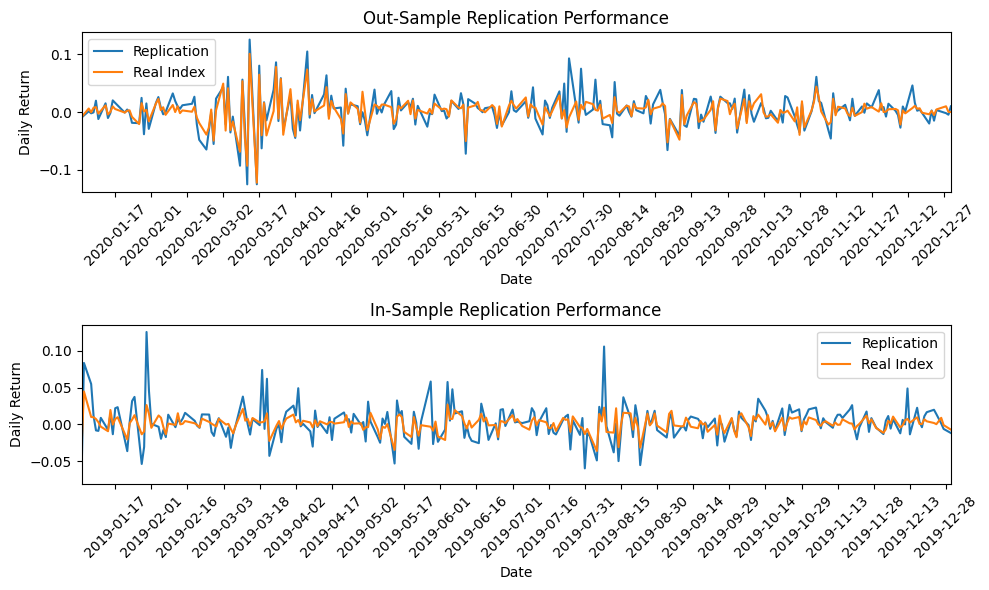

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(future.index, future['Portfolio'], label='Replication')
ax1.plot(future.index, future['Index'], label='Real Index')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_xlabel('Date')
ax1.set_xlim(future.index[0], future.index[-1])
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Daily Return')
ax1.set_title('Out-Sample Replication Performance')
ax1.legend()

ax2.plot(past.index, past['Portfolio'], label='Replication')
ax2.plot(past.index, past['Index'], label='Real Index')
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=15, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.set_xlabel('Date')
ax2.set_xlim(past.index[0], past.index[-1])
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Daily Return')
ax2.set_title('In-Sample Replication Performance')
ax2.legend()

plt.tight_layout()
plt.show()

# Re-do with new m's

In [ ]:
m_list = [i for i in range(10, 101, 10)]

In [ ]:
trials = pd.DataFrame(columns=['Value of m', 'Prediction Error'])
trials.loc[0] = [m, forward_error]
trials

,Value of m,Prediction Error
0,5.0,1.112437


In [ ]:
for m in tqdm(m_list):
  try:
    selection = gp.Model(env=env)
    X = selection.addMVar((n,n), vtype='B')
    Y = selection.addMVar(n, vtype='B')
    target = gp.quicksum(gp.quicksum(X[i][j]*rho_train.iloc[i, j] for i in range(n)) for j in range(n))
    selection.setObjective(target, sense=gp.GRB.MAXIMIZE)
    total_con = selection.addConstr(gp.quicksum(Y[j] for j in range(n))==m)
    row_con = selection.addConstrs(gp.quicksum(X[i][j] for j in range(n))==1 for i in range(n))
    select_con = selection.addConstrs(X[i][j]<=Y[j] for i in range(n) for j in range(n))
    selection.Params.OutputFlag = 0
    selection.optimize()
    Y_indices = np.where(Y.x == 1)
    selected_return = train_return.iloc[:,Y_indices[0].tolist()]
    weight = gp.Model(env=env)
    y = weight.addMVar(T)
    w = weight.addMVar(m)
    sum_con = weight.addConstr(sum(w)==1)
    y_form = [train_q[t]-gp.quicksum(selected_return.iloc[t,i]*w[i] for i in range(m)) for t in range(T)]
    up_con = weight.addConstrs(y[t]>=y_form[t] for t in range(T))
    down_con = weight.addConstrs(y[t]>=-y_form[t] for t in range(T))
    weight.setObjective(sum(y), sense=gp.GRB.MINIMIZE)
    weight.Params.OutputFlag = 0
    weight.optimize()
    selected_return2 = test_return.iloc[:,Y_indices[0].tolist()]
    error = gp.quicksum(abs(test_q[t]-gp.quicksum(selected_return2.iloc[t,i]*w.x[i] for i in range(m)).getValue()) for t in range(T2)).getValue()
    trials.loc[len(trials.index)]=[m, error]
    print(trials.loc[len(trials.index)-1])
  except:
    break
trials

  0%|          | 0/10 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 10%|█         | 1/10 [00:39<05:57, 39.73s/it]

Value of m          10.000000
Prediction Error     1.102404
Name: 1, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 20%|██        | 2/10 [01:13<04:48, 36.05s/it]

Value of m          20.000000
Prediction Error     0.899598
Name: 2, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 30%|███       | 3/10 [01:49<04:12, 36.03s/it]

Value of m          30.00000
Prediction Error     0.76911
Name: 3, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 40%|████      | 4/10 [02:26<03:39, 36.55s/it]

Value of m          40.000000
Prediction Error     0.791047
Name: 4, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 50%|█████     | 5/10 [03:05<03:07, 37.52s/it]

Value of m          50.0000
Prediction Error     0.7721
Name: 5, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 60%|██████    | 6/10 [03:48<02:37, 39.27s/it]

Value of m          60.000000
Prediction Error     1.097304
Name: 6, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 70%|███████   | 7/10 [04:32<02:02, 40.91s/it]

Value of m          70.000000
Prediction Error     0.557854
Name: 7, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 80%|████████  | 8/10 [05:18<01:24, 42.39s/it]

Value of m          80.000000
Prediction Error     0.537323
Name: 8, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 90%|█████████ | 9/10 [06:06<00:44, 44.14s/it]

Value of m          90.00000
Prediction Error     0.36779
Name: 9, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


100%|██████████| 10/10 [06:56<00:00, 41.64s/it]

Value of m          100.000000
Prediction Error      0.368671
Name: 10, dtype: float64


,Value of m,Prediction Error
0,5.0,1.112437
1,10.0,1.102404
2,20.0,0.899598
3,30.0,0.769110
4,40.0,0.791047
5,50.0,0.772100
6,60.0,1.097304
7,70.0,0.557854
8,80.0,0.537323
9,90.0,0.367790


In [ ]:
back_trials = pd.DataFrame(columns=['Value of m', 'Prediction Error'])
back_trials.loc[0] = [5, back_error]
back_trials

,Value of m,Prediction Error
0,5.0,0.789178


In [ ]:
# see how the portfolio does with the 2019 data - m=100 probably does best
for m in tqdm(m_list):
  selection = gp.Model(env=env)
  X = selection.addMVar((n,n), vtype='B')
  Y = selection.addMVar(n, vtype='B')
  target = gp.quicksum(gp.quicksum(X[i][j]*rho_train.iloc[i, j] for i in range(n)) for j in range(n))
  selection.setObjective(target, sense=gp.GRB.MAXIMIZE)
  total_con = selection.addConstr(gp.quicksum(Y[j] for j in range(n))==m)
  row_con = selection.addConstrs(gp.quicksum(X[i][j] for j in range(n))==1 for i in range(n))
  select_con = selection.addConstrs(X[i][j]<=Y[j] for i in range(n) for j in range(n))
  selection.Params.OutputFlag = 0
  selection.optimize()
  Y_indices = np.where(Y.x == 1)
  selected_return = train_return.iloc[:,Y_indices[0].tolist()]
  weight = gp.Model(env=env)
  y = weight.addMVar(T)
  w = weight.addMVar(m)
  sum_con = weight.addConstr(sum(w)==1)
  y_form = [train_q[t]-gp.quicksum(selected_return.iloc[t,i]*w[i] for i in range(m)) for t in range(T)]
  up_con = weight.addConstrs(y[t]>=y_form[t] for t in range(T))
  down_con = weight.addConstrs(y[t]>=-y_form[t] for t in range(T))
  weight.setObjective(sum(y), sense=gp.GRB.MINIMIZE)
  weight.Params.OutputFlag = 0
  weight.optimize()
  error = gp.quicksum(abs(train_q[t]-gp.quicksum(selected_return.iloc[t,i]*w.x[i] for i in range(m)).getValue()) for t in range(T)).getValue()
  back_trials.loc[len(back_trials.index)]=[m, error]
  print(back_trials.loc[len(back_trials.index)-1])
back_trials

  0%|          | 0/10 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 10%|█         | 1/10 [00:31<04:39, 31.05s/it]

Value of m          10.000000
Prediction Error     0.701218
Name: 1, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 20%|██        | 2/10 [01:04<04:20, 32.56s/it]

Value of m          20.000000
Prediction Error     0.478836
Name: 2, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 30%|███       | 3/10 [01:39<03:56, 33.78s/it]

Value of m          30.000000
Prediction Error     0.418015
Name: 3, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 40%|████      | 4/10 [02:17<03:30, 35.16s/it]

Value of m          40.000000
Prediction Error     0.370517
Name: 4, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 50%|█████     | 5/10 [02:56<03:03, 36.74s/it]

Value of m          50.00000
Prediction Error     0.33254
Name: 5, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 60%|██████    | 6/10 [03:38<02:33, 38.36s/it]

Value of m          60.00000
Prediction Error     0.34489
Name: 6, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 70%|███████   | 7/10 [04:21<01:59, 39.86s/it]

Value of m          70.000000
Prediction Error     0.169824
Name: 7, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 80%|████████  | 8/10 [05:07<01:23, 41.82s/it]

Value of m          80.000000
Prediction Error     0.147683
Name: 8, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 90%|█████████ | 9/10 [05:55<00:43, 43.88s/it]

Value of m          90.000000
Prediction Error     0.053779
Name: 9, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


100%|██████████| 10/10 [06:45<00:00, 40.57s/it]

Value of m          100.000000
Prediction Error      0.044911
Name: 10, dtype: float64


,Value of m,Prediction Error
0,5.0,0.789178
1,10.0,0.701218
2,20.0,0.478836
3,30.0,0.418015
4,40.0,0.370517
5,50.0,0.332540
6,60.0,0.344890
7,70.0,0.169824
8,80.0,0.147683
9,90.0,0.053779


In [ ]:
trials.set_index('Value of m', inplace=True)

In [ ]:
back_trials.set_index('Value of m', inplace=True)

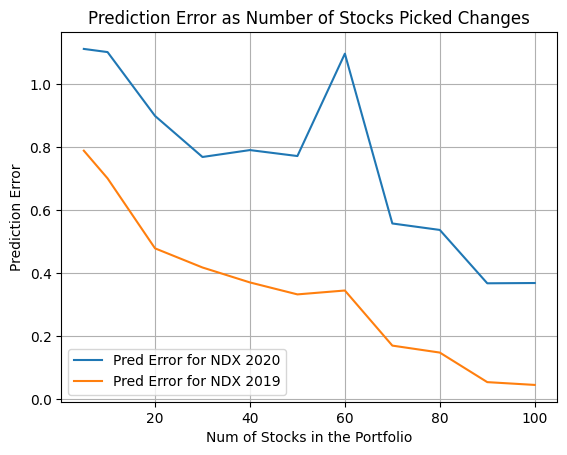

In [ ]:
plt.plot(trials.index, trials['Prediction Error'], label='Pred Error for NDX 2020')
plt.plot(back_trials.index, back_trials['Prediction Error'], label='Pred Error for NDX 2019')
plt.title('Prediction Error as Number of Stocks Picked Changes')
plt.xlabel('Num of Stocks in the Portfolio')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.legend()
plt.show()

# New Method

## Try the first m=5

In [ ]:
m = 5
M = 1

In [ ]:
new = gp.Model(env=env)
newY = new.addMVar(n, vtype='B')
newW = new.addMVar(n)
newy = new.addMVar(T)
new.Params.TimeLimit = 20

Set parameter TimeLimit to value 20


In [ ]:
y_form = [train_q[t]-gp.quicksum(train_return.iloc[t,i]*newW[i] for i in range(n)) for t in range(T)]
new.setObjective(sum(newy), sense=gp.GRB.MINIMIZE)

In [ ]:
up_con = new.addConstrs(newy[t]>=y_form[t] for t in range(T))
down_con = new.addConstrs(newy[t]>=-y_form[t] for t in range(T))

In [ ]:
sum_con = new.addConstr(sum(newW)==1)
num_con = new.addConstr(sum(newY)==m)
M_con = new.addConstrs(newW[i]<=newY[i]*M for i in range(n))

In [ ]:
new.Params.OutputFlag = 0
new.optimize()

In [ ]:
forward_error = gp.quicksum(abs(test_q[t]-gp.quicksum(test_return.iloc[t,i]*newW.x[i] for i in range(n)).getValue()) for t in range(T2)).getValue()

In [ ]:
forward_error

0.8891779700926835

In [ ]:
back_error = gp.quicksum(abs(train_q[t]-gp.quicksum(train_return.iloc[t,i]*newW.x[i] for i in range(n)).getValue()) for t in range(T)).getValue()

In [ ]:
back_error

0.5788340254038576

In [ ]:
column = ['m', 'forward', 'back'] + [f'weight{i+1}' for i in range(100)]
summary = pd.DataFrame(columns=column)
summary.loc[len(summary.columns)] = [m, forward_error, back_error] + newW.x.tolist()
summary

,m,forward,back,weight1,weight2,weight3,weight4,weight5,weight6,weight7,...,weight91,weight92,weight93,weight94,weight95,weight96,weight97,weight98,weight99,weight100
103,5.0,0.889178,0.578834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057532


## Then do all ms

In [ ]:
from google.colab import files
M = 1
m_list = [5] + [i for i in range(10, 101, 10)]
column = ['m', 'forward', 'back'] + [f'weight{i+1}' for i in range(100)]
summary = pd.DataFrame(columns=column)
for m in tqdm(m_list):
  try:
    new = gp.Model(env=env)
    newY = new.addMVar(n, vtype='B')
    newW = new.addMVar(n)
    newy = new.addMVar(T)
    new.Params.TimeLimit = 3600
    y = [train_q[t]-gp.quicksum(train_return.iloc[t,i]*newW[i] for i in range(n)) for t in range(T)]
    new.setObjective(sum(newy), sense=gp.GRB.MINIMIZE)
    up_con = new.addConstrs(newy[t]>=y[t] for t in range(T))
    down_con = new.addConstrs(newy[t]>=-y[t] for t in range(T))
    sum_con = new.addConstr(sum(newW)==1)
    num_con = new.addConstr(sum(newY)==m)
    M_con = new.addConstrs(newW[i]<=newY[i]*M for i in range(n))
    new.Params.OutputFlag = 0
    new.optimize()
    forward_error = gp.quicksum(abs(test_q[t]-gp.quicksum(test_return.iloc[t,i]*newW.x[i] for i in range(n)).getValue()) for t in range(T2)).getValue()
    back_error = gp.quicksum(abs(train_q[t]-gp.quicksum(train_return.iloc[t,i]*newW.x[i] for i in range(n)).getValue()) for t in range(T)).getValue()
    summary.loc[len(summary.index)]=[m, forward_error, back_error] + newW.x.tolist()
    summary.to_csv(f'Summary{m}.csv', index=False)
  except:
    break
summary.to_csv('Summary.csv', index=False)
from google.colab import files
files.download('Summary.csv')

## And evaluate performance of the new method against the old one

In [ ]:
new_method = pd.read_csv('Summary.csv', index_col=0)
new_method

,forward,back,weight1,weight2,weight3,weight4,weight5,weight6,weight7,weight8,...,weight91,weight92,weight93,weight94,weight95,weight96,weight97,weight98,weight99,weight100
m,,,,,,,,,,,,,,,,,,,,,
5.0,0.777362,0.499259,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.250123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
10.0,0.753372,0.290137,0.000000,0.000000,0.000000,0.000000,0.0,0.093503,0.000000,0.125808,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.041476,0.000000,0.0,0.000000,0.000000
20.0,0.510008,0.170808,0.000000,0.030952,0.000000,0.000000,0.0,0.088731,0.000000,0.111671,...,0.000000,0.000000,0.000000,0.052106,0.000000,0.023386,0.000000,0.0,0.000000,0.000000
30.0,0.498795,0.107982,0.007593,0.020084,0.008172,0.000000,0.0,0.091512,0.000000,0.102804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
40.0,0.407864,0.081826,0.005660,0.030373,0.000000,0.010297,0.0,0.000000,0.081002,0.094175,...,0.000000,0.000000,0.026119,0.019191,0.000000,0.012680,0.000000,0.0,0.000000,0.008066
50.0,0.384045,0.062334,0.004751,0.025698,0.005409,0.000000,0.0,0.087415,0.000000,0.095032,...,0.000000,0.003724,0.000000,0.000000,0.007372,0.009194,0.000000,0.0,0.000000,0.000000
60.0,0.363881,0.053257,0.003637,0.017511,0.004388,0.000000,0.0,0.087037,0.000000,0.102891,...,0.000000,0.003993,0.008927,0.000000,0.009503,0.009440,0.004105,0.0,0.000000,0.004934
70.0,0.373896,0.047577,0.003702,0.018122,0.003507,0.000000,0.0,0.088208,0.000000,0.095983,...,0.000000,0.004334,0.007927,0.000000,0.007692,0.008081,0.002700,0.0,0.000000,0.004417
80.0,0.370629,0.045227,0.003119,0.017845,0.003566,0.001275,0.0,0.057147,0.027985,0.096184,...,0.000000,0.004054,0.007078,0.005699,0.007782,0.009250,0.002624,0.0,0.000000,0.005633


### Horizontal comparison - compare across m values

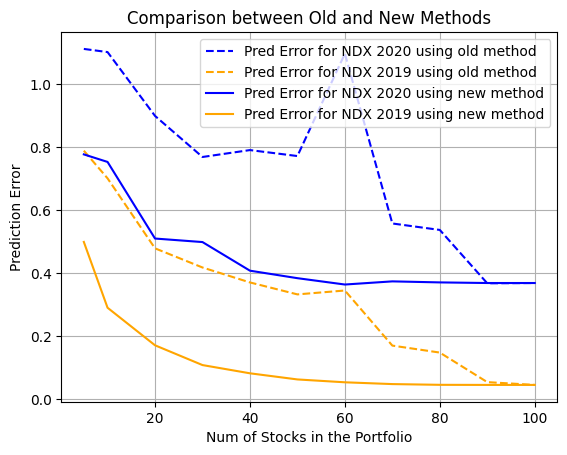

In [ ]:
plt.plot(trials.index, trials['Prediction Error'], label='Pred Error for NDX 2020 using old method', linestyle='dashed', color='blue')
plt.plot(back_trials.index, back_trials['Prediction Error'], label='Pred Error for NDX 2019 using old method', linestyle='dashed', color='orange')
plt.plot(new_method.index, new_method['forward'], label='Pred Error for NDX 2020 using new method', color='blue')
plt.plot(new_method.index, new_method['back'], label='Pred Error for NDX 2019 using new method', color='orange')
plt.title('Comparison between Old and New Methods')
plt.xlabel('Num of Stocks in the Portfolio')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.legend()
plt.show()

### Vertical comparison - compare across time (m=5)

In [ ]:
m=5
# everything automated if you change the m value here, no need to change any number down below
row = new_method.index.get_loc(m)
past = selected_return.copy()
past['Index'] = train_q
old_rep = [sum([selected_return.iloc[i,j]*weight_grid.iloc[row,j] for j in range(m)]) for i in range(T)]
past['Old_Portfolio'] = old_rep
new_rep = [sum([selected_return.iloc[i,j]*new_method.iloc[row,j+2] for j in range(n)]) for i in range(T)]
past['New_Portfolio'] = new_rep
future = selected_return2.copy()
future['Index'] = test_q
old_rep2 = [sum([selected_return2.iloc[i,j]*weight_grid.iloc[row,j] for j in range(m)]) for i in range(T2)]
future['Old_Portfolio'] = old_rep2
new_rep = [sum([selected_return2.iloc[i,j]*new_method.iloc[row,j+2] for j in range(n)]) for i in range(T2)]
future['New_Portfolio'] = new_rep
future.index = pd.to_datetime(pd.to_datetime(future.index).strftime('%Y-%m-%d'))
past.index = pd.to_datetime(past.index)

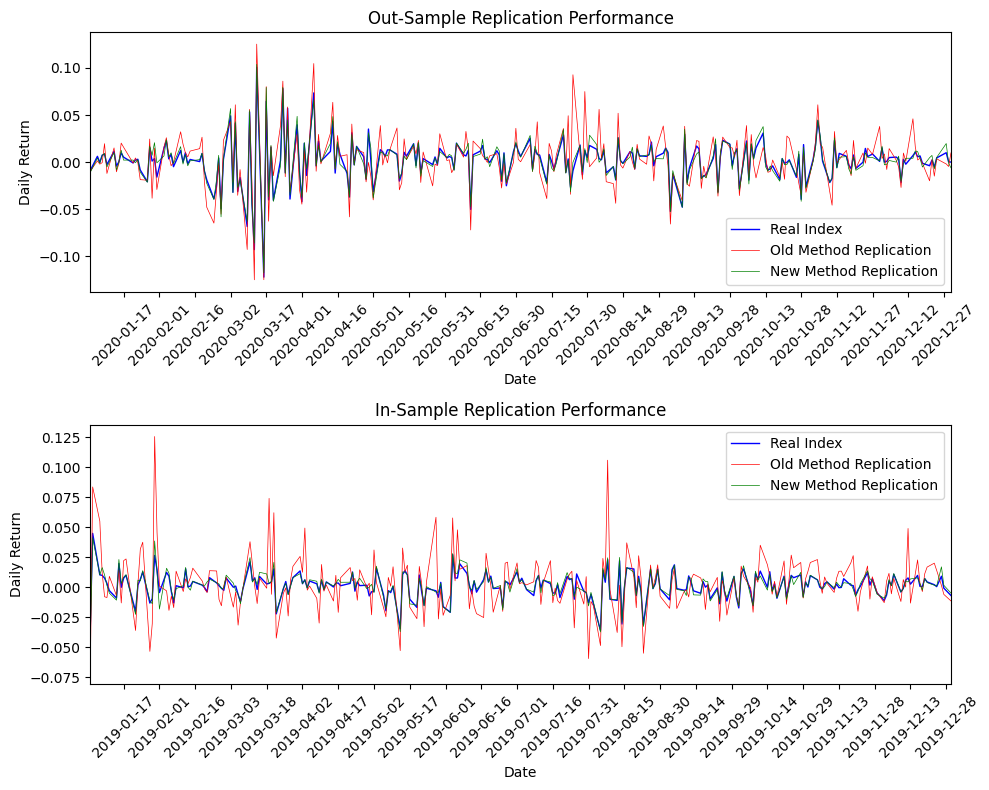

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(future.index, future['Index'], label='Real Index', linewidth=1, color='blue')
ax1.plot(future.index, future['Old_Portfolio'], label='Old Method Replication', linewidth=0.5, color='red')
ax1.plot(future.index, future['New_Portfolio'], label='New Method Replication', linewidth=0.5, color='green')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_xlim(future.index[0], future.index[-1])
ax1.set_xlabel('Date')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Daily Return')
ax1.set_title('Out-Sample Replication Performance')
ax1.legend()

ax2.plot(past.index, past['Index'], label='Real Index', linewidth=1, color='blue')
ax2.plot(past.index, past['Old_Portfolio'], label='Old Method Replication', linewidth=0.5, color='red')
ax2.plot(past.index, past['New_Portfolio'], label='New Method Replication', linewidth=0.5, color='green')
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.set_xlim(past.index[0], past.index[-1])
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Daily Return')
ax2.set_title('In-Sample Replication Performance')
ax2.legend()

plt.tight_layout()
plt.show()